In [34]:
from torch.utils.data import Dataset
import os  
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm
# preprocess the data samples
from segmentation_models_pytorch.encoders import get_preprocessing_fn
class CustomDataset(Dataset):
    def __init__(self, root_dir, data_type='train', transform=None):
        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform  
        self.image_dir = f'{root_dir}/{data_type}/images/'
        self.mask_dir = f'{root_dir}/{data_type}/masks/'
        self.image_paths = sorted(os.listdir(self.image_dir))


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #shuffle_data(self.image_paths)
        image_path = os.path.join(self.image_dir, self.image_paths[idx])

        image = Image.open(image_path)
        mask_path = os.path.join(self.mask_dir, self.image_paths[idx])
        mask = Image.open(mask_path)


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to PyTorch tensor
])
    

train_dataset = CustomDataset(root_dir='Dataset', data_type='train', transform=transform)
val_dataset = CustomDataset(root_dir='Dataset', data_type='val', transform=transform)
test_dataset = CustomDataset(root_dir='Dataset', data_type='test', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16, shuffle=True)



In [35]:
num_classes = len(np.unique(train_dataset[0][1])) # 2 classes: [0, 1]
print(f"Unique classes: {num_classes}")


Unique classes: 10


In [36]:
model = smp.Unet(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=num_classes, activation="softmax", aux_params=None)  # num_classes is the number of segmentation classes
encoder_name = 'resnet34'

# Create the preprocessing function for the chosen encoder
preprocess_input = get_preprocessing_fn(encoder_name, pretrained='imagenet')

criterion = torch.nn.CrossEntropyLoss()  # Use a suitable loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Use an appropriate optimizer
num_epochs = 100
early_stopping_patience = 5  # Number of epochs with no improvement to wait before stopping
best_val_loss = float('inf')
patience_counter = 0

# Define the mean values for the RGB channels
mean = [0.485, 0.456, 0.406]  # These are the mean values used for ImageNet pretraining

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.argmax(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            targets = targets.argmax(dim=1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check if the validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model checkpoint here if needed

    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

/home/cipher73/.local/lib/python3.10/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch [1/2] - Train Loss: 2.2536, Val Loss: 2.4163
Epoch [2/2] - Train Loss: 2.1374, Val Loss: 2.4171


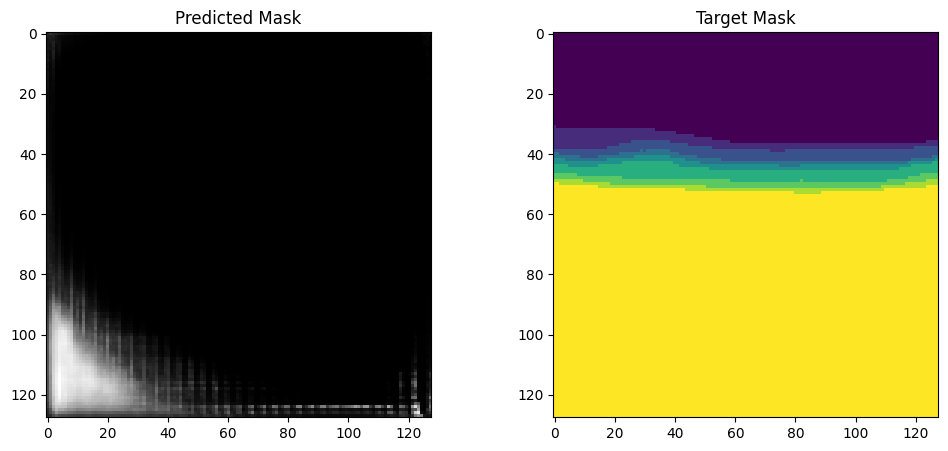

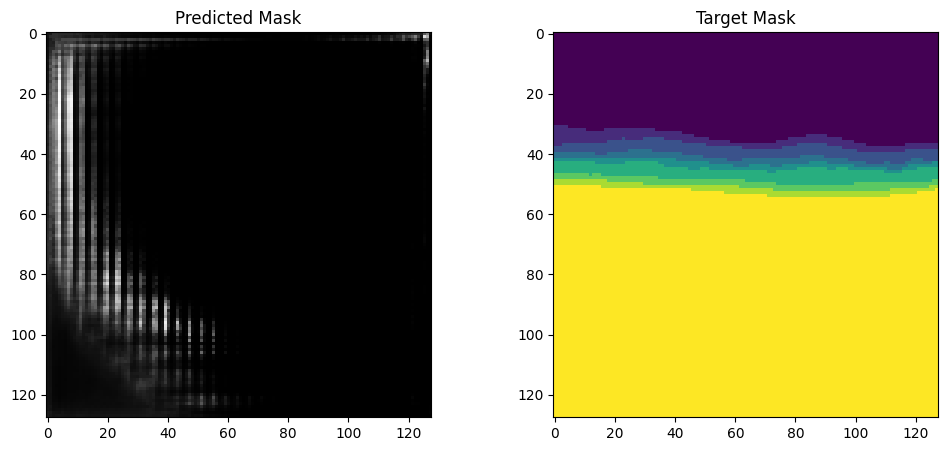

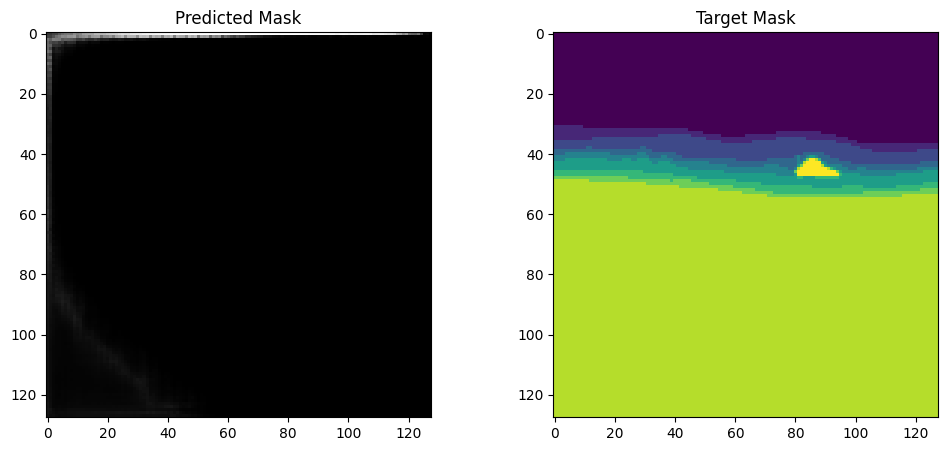

In [37]:
# Inference on a test batch
model.eval()
with torch.no_grad():
    test_batch = next(iter(test_loader))  # Get a test batch
    test_inputs, _ = test_batch  # Extract input images
    predictions = model(test_inputs)  # Perform inference on the test batch

# Visualize the output masks
# Assuming 'predictions' and 'targets' are tensors
batch_index = 0  # Index of the batch you want to visualize
num_masks_to_visualize = 3  # Number of masks to visualize

predicted_masks = predictions[batch_index].cpu().numpy()  # Convert tensor to NumPy array

for i in range(num_masks_to_visualize):
    image, mask = test_dataset[i]  # get some sample
    plt.figure(figsize=(12, 5))

    # Plot predicted mask
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_masks[i], cmap='gray')
    plt.title('Predicted Mask')
    
    # Plot target mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0))
    plt.title('Target Mask')

    plt.show()


In [37]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch as smp
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, data_type='train', transform=None):
        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform
        self.image_dir = os.path.join(root_dir, data_type, 'images')
        self.mask_dir = os.path.join(root_dir, data_type, 'masks')
        self.image_paths = sorted(os.listdir(self.image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(image_path)
        mask_path = os.path.join(self.mask_dir, self.image_paths[idx])
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = CustomDataset(root_dir='Dataset', data_type='train', transform=transform)
val_dataset = CustomDataset(root_dir='Dataset', data_type='val', transform=transform)
test_dataset = CustomDataset(root_dir='Dataset', data_type='test', transform=transform)

# Data Loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model and Preprocessing
encoder_name = 'resnet34'
preprocess_input = get_preprocessing_fn(encoder_name, pretrained='imagenet')
num_classes = 2  # Adjust based on your dataset

model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
)

# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.argmax(dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Val)'):
            inputs, targets = batch
            outputs = model(inputs)
            print(outputs.shape)
            print(targets.shape)
            loss = criterion(outputs, targets.argmax(dim=1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model checkpoint here if needed
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break



Epoch 1/50 (Val): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


torch.Size([16, 2, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([6, 2, 128, 128])
torch.Size([6, 1, 128, 128])
Epoch [1/50] - Train Loss: 0.7598, Val Loss: 2.5048


Epoch 2/50:  40%|████      | 2/5 [00:02<00:04,  1.45s/it]


KeyboardInterrupt: 

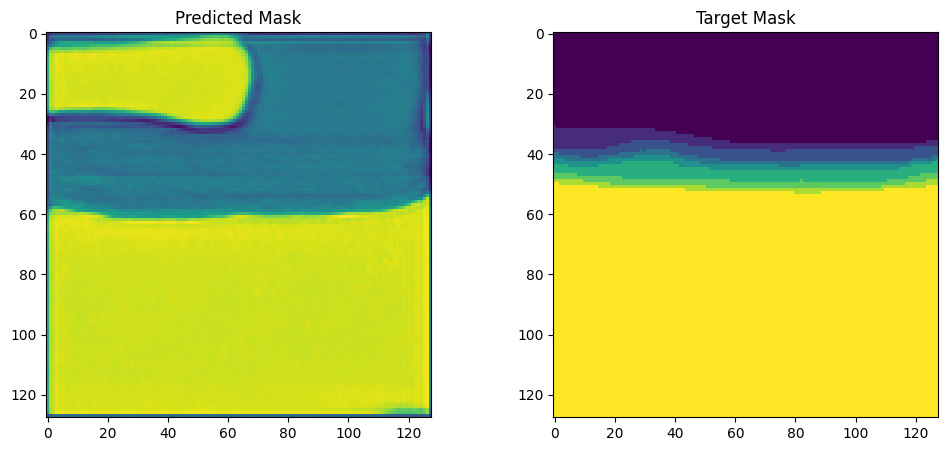

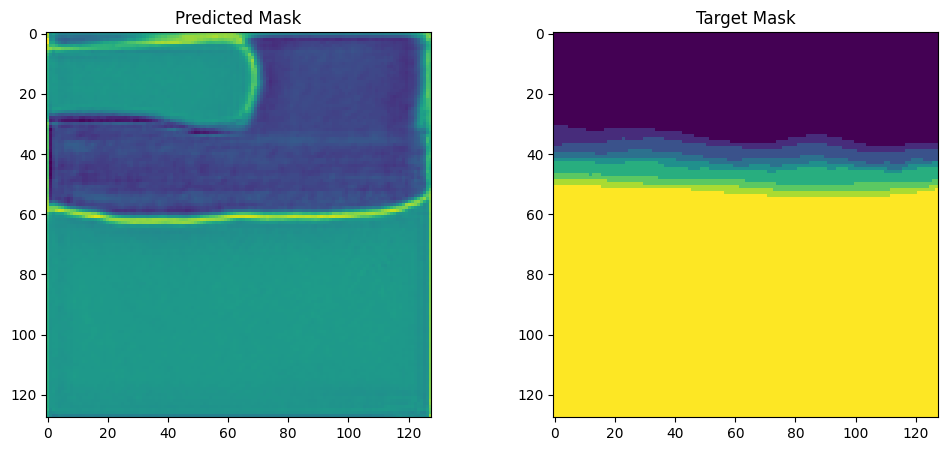

In [ ]:
# Inference on a test batch
model.eval()
with torch.no_grad():
    test_batch = next(iter(test_loader))
    test_inputs, _ = test_batch
    predictions = model(test_inputs)

# Visualize the output masks
batch_index = 0

# Ensure num_masks_to_visualize does not exceed the number of masks
num_masks_to_visualize = min(num_masks_to_visualize, predicted_masks.shape[0])

for i in range(num_masks_to_visualize):
    image, mask = test_dataset[i]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_masks[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.permute(1, 2, 0))
    plt.title('Target Mask')

    plt.show()



(256, 256)


Text(0.5, 1.0, 'Segmented Mask')

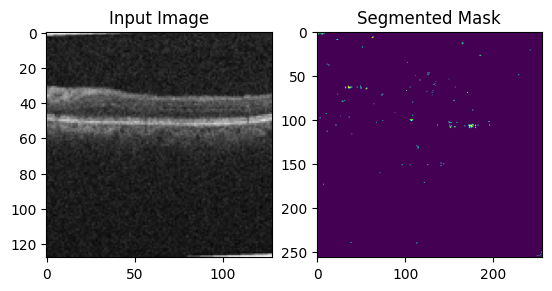

In [ ]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from segmentation_models_pytorch import Unet

# Load a pre-trained model (you can choose a different one if needed)
model = Unet('resnet34', encoder_weights='imagenet',classes=11, activation='softmax')

# Load and preprocess the input image
image_path = 'Subject_09_00.tif'
input_image = Image.open(image_path).convert('RGB')
image = input_image
transform = T.Compose([T.Resize((256, 256)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
input_image = transform(input_image).unsqueeze(0)

# Make a prediction
with torch.no_grad():
    output = model(input_image)

# You can apply a threshold or post-processing to the output mask as needed
# For simplicity, we'll apply a threshold here to create a binary mask
threshold = 0.5
binary_mask = (output > threshold).float()

# Convert the tensor to a numpy array
binary_mask = binary_mask.squeeze().cpu().numpy()

# Display the input image and the segmented mask
plt.subplot(1, 2, 1)

plt.imshow(image)
plt.title("Input Image")

binary_mask = binary_mask.argmax(axis=0)
print(binary_mask.shape)

plt.subplot(1, 2, 2)
plt.imshow(binary_mask)
plt.title("Segmented Mask")


In [68]:
import torch
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from segmentation_models_pytorch import Unet
import segmentation_models_pytorch.encoders as encoders
from segmentation_models_pytorch.utils.metrics import IoU

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, data_type='train', transform=None):
        self.root_dir = root_dir
        self.data_type = data_type
        self.transform = transform
        self.image_dir = os.path.join(root_dir, data_type, 'images')
        self.mask_dir = os.path.join(root_dir, data_type, 'masks')
        self.image_paths = sorted(os.listdir(self.image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(image_path)
        mask_path = os.path.join(self.mask_dir, self.image_paths[idx])
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = CustomDataset(root_dir='Dataset', data_type='train', transform=transform)
val_dataset = CustomDataset(root_dir='Dataset', data_type='val', transform=transform)
test_dataset = CustomDataset(root_dir='Dataset', data_type='test', transform=transform)

# Data Loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



Epoch [1/10] - Val Loss: 0.06234171241521835
Epoch [2/10] - Val Loss: 0.06234171241521835
Epoch [3/10] - Val Loss: 0.06234171241521835
Epoch [4/10] - Val Loss: 0.06234186887741089
Epoch [5/10] - Val Loss: 0.062341779470443726
Epoch [6/10] - Val Loss: 0.06234174221754074
Epoch [7/10] - Val Loss: 0.06234172731637955
Epoch [8/10] - Val Loss: 0.06234171614050865
Epoch [9/10] - Val Loss: 0.06234171241521835
Epoch [10/10] - Val Loss: 0.06234171614050865


/home/cipher73/.local/lib/python3.10/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch [1/10] - Loss: 0.07548796683549881
Epoch [2/10] - Loss: 0.0739767849445343
Epoch [3/10] - Loss: 0.07164272218942642
Epoch [4/10] - Loss: 0.06931252032518387
Epoch [5/10] - Loss: 0.0675932914018631
Epoch [6/10] - Loss: 0.06628353893756866
Epoch [7/10] - Loss: 0.06517065316438675
Epoch [8/10] - Loss: 0.06380910128355026
Epoch [9/10] - Loss: 0.06215926706790924
Epoch [10/10] - Loss: 0.06040105819702148


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

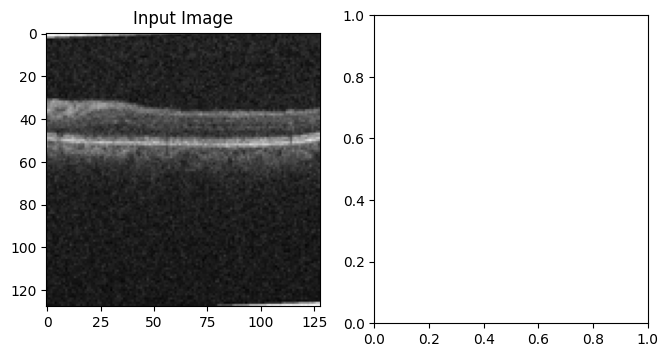

In [73]:

# Define the segmentation model (Unet in this case)
model = Unet(encoder_name='resnet34', in_channels=3, classes=11, activation='softmax')

# Define the loss function
criterion = DiceLoss(mode='multiclass')

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    #shuffle_data(train_loader)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for images, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.argmax(dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {running_loss / len(train_loader)}')

# Testing loop
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        outputs = model(images)
        predicted_masks = outputs.argmax(dim=1).squeeze().cpu().numpy()
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0].permute(1, 2, 0))
        plt.title("Input Image")
        
        plt.subplot(1, 3, 2)
        plt.imshow(masks[0].unsqueeze(0).permute(1, 2, 0))
        plt.title("Real Mask")
        
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks, cmap='jet')
        plt.title("Predicted Mask")
        
        plt.show()